# Load in Data

In [1]:
import pandas as pd
import numpy as np
import re
from scipy.stats import ttest_ind
import scipy.stats
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20,12)

In [2]:
df = pd.read_csv('../data/raw/Customer_Dataset_File.csv')
df.replace('#NULL!', np.NaN, inplace=True)

# Create Modules to Use Throughout Process

In [3]:
# define module to create frequency distribution of variables
def freq_dist(df, col):
    df_fd = pd.DataFrame(data=df[col].value_counts())
    df_fd['pct_total'] = df_fd[col] / df_fd[col].sum()
    print(df_fd.head(15))
    
# define module to convert individual values in to buckets, creating corresponding labels; 
# outputs frequency distribution module above
def creat_bins(df, new_col, col, bins=[], labels=[]):
    df[new_col] = pd.cut(
    x=df[col], 
    bins=bins, 
    labels=labels)
    freq_dist(df, new_col)
    
    
#Module used to take a field in dollars seen as an 'object' and convert in to an Integer    
def convert_dollars(cols):
    df[cols] = df[cols].str.replace('#NULL!', '0.0')
    df[cols] = df[cols].str.replace(',', '')
    df[cols] = df[cols].str.replace('$', '')
    df[cols] = df[cols].str.replace(' ', '')
    df[cols] = df[cols].str.replace(')', '')
    df[cols] = df[cols].str.replace('-', '0.0')
    df[cols] = df[cols].str.replace('(', '-')
    df[cols] = df[cols].astype(float)
    df[cols] = df[cols].replace('.0', '')
    df[cols] = df[cols].astype(int)
    print('Converting', cols, 'Dollars to Numbers Complete')
    
    
    
    
#Creates Histogram for Comparitive Purposes
def review_detail(df, equil, col, num, col2, num2, col3, meas, sub, type):    
    if type == 'total':
        df_last_month = df.loc[(df[col] != num) & (df[col2] != num2)]
        df_last_month = df_last_month.groupby(by=[col, col3, col2]).agg({'Total'+equil:meas})
        df_last_month.rename(columns = {'index':col3}, inplace=True)
        df_last_month['pct_total'] = ((df_last_month['Total'+equil] / df_last_month['Total'+equil].sum())*100).astype(int)
        df_last_month = pd.DataFrame(df_last_month)
        df_last_month = df_last_month.T
        print(df_last_month)
        df_last_month.drop_duplicates(inplace=True)
        df_last_month = df_last_month.T
        df_last_month.drop(columns=['pct_total'], inplace=True)


        df_last_month.unstack().plot(kind='bar', use_index=True, rot=0, 
                                     subplots=sub, title=(meas+' by '+col2))
    else:
        df_last_month = df.loc[(df[col] != num) & (df[col2] != num2)]
        df_last_month = df_last_month.groupby(by=[col, col3, col2]).agg({'Voice'+equil:meas, 
                                                                         'Equipment'+equil:meas, 
                                                                         'Data'+equil:meas})
        df_last_month.rename(columns = {'index':col3}, inplace=True)
        df_last_month = pd.DataFrame(df_last_month)
        print(df_last_month.head().T)

        df_last_month.unstack().plot(kind='bar', use_index=True, rot=0, 
                                     subplots=sub, title=(meas+' by '+col2))

# Examine Dataset: 

### Examine Shape (Rows and Columns)

In [4]:
rows = len(df)
columns = len(df.columns)
values = rows*columns
non_na = df.count().sum()
na = values-non_na

print('Number of rows:', rows, '\n')
print('Number of columns:', columns, '\n')

Number of rows: 5000 

Number of columns: 59 



### Review missing data cells

In [5]:
print('Total cells:', values, '\n')
print('Total values:', non_na, '\n')
print('Missing values:', na, '\n')

Total cells: 295000 

Total values: 294872 

Missing values: 128 



### Review Columns

In [6]:
print('Below is the current list of columns loaded: \n\n',
      df.columns, '\n\n **Removed the following columns before starting',
      'analysis: NumberPets, NumberCats, NumberDogs, NumberBirds.')

Below is the current list of columns loaded: 

 Index(['CustomerID', 'Region', 'TownSize', 'Gender', 'Age', 'EducationYears',
       'JobCategory', 'UnionMember', 'EmploymentLength', 'Retired', 'HHIncome',
       'DebtToIncomeRatio', 'CreditDebt', 'OtherDebt', 'LoanDefault',
       'MaritalStatus', 'HouseholdSize', 'NumberPets', 'NumberCats',
       'NumberDogs', 'NumberBirds', 'HomeOwner', 'CarsOwned', 'CarOwnership',
       'CarBrand', 'CarValue', 'CommuteTime', 'PoliticalPartyMem', 'Votes',
       'CreditCard', 'CardTenure', 'CardItemsMonthly', 'CardSpendMonth',
       'ActiveLifestyle', 'PhoneCoTenure', 'VoiceLastMonth', 'VoiceOverTenure',
       'EquipmentRental', 'EquipmentLastMonth', 'EquipmentOverTenure',
       'CallingCard', 'WirelessData', 'DataLastMonth', 'DataOverTenure',
       'Multiline', 'VM', 'Pager', 'Internet', 'CallerID', 'CallWait',
       'CallForward', 'ThreeWayCalling', 'EBilling', 'TVWatchingHours',
       'OwnsPC', 'OwnsMobileDevice', 'OwnsGameSystem', 'OwnsF

In [7]:
df= df[['CustomerID','Region', 'TownSize', 'Gender', 'Age', 'EducationYears',
       'JobCategory', 'UnionMember', 'EmploymentLength', 'Retired', 'HHIncome',
       'DebtToIncomeRatio', 'CreditDebt', 'OtherDebt', 'LoanDefault',
       'MaritalStatus', 'HouseholdSize', 'HomeOwner', 'CarsOwned', 'CarOwnership',
       'CarBrand', 'CarValue', 'CommuteTime', 'PoliticalPartyMem', 'Votes', 
        'CardTenure', 'CardItemsMonthly', 'CardSpendMonth',
       'ActiveLifestyle', 'PhoneCoTenure', 'VoiceLastMonth', 'VoiceOverTenure',
       'EquipmentRental', 'EquipmentLastMonth', 'EquipmentOverTenure',
       'CallingCard', 'WirelessData', 'DataLastMonth', 'DataOverTenure',
       'Multiline', 'VM', 'Pager', 'Internet', 'CallerID', 'CallWait',
       'CallForward', 'ThreeWayCalling', 'EBilling', 'TVWatchingHours',
       'OwnsPC', 'OwnsMobileDevice', 'OwnsGameSystem', 'OwnsFax',
       'NewsSubscriber']]

In [8]:
print('Below is a list of columns that have missing values:')
#Highlight what columns have missing values
[col for col in df.columns if df[col].isnull().any()]

Below is a list of columns that have missing values:


['TownSize',
 'Gender',
 'JobCategory',
 'HouseholdSize',
 'HomeOwner',
 'CommuteTime']

### Fill missing value cells with guestimations

In [9]:
#Replacing missing values with means: TownSize
df['TownSize'] = pd.to_numeric(df['TownSize'], errors='coerce')
df.TownSize.fillna(df.TownSize.mean(), inplace=True)
df['TownSize'] = df['TownSize'].astype(int)
freq_dist(df, 'TownSize')

   TownSize  pct_total
1      1436     0.2872
2      1050     0.2100
3       907     0.1814
4       857     0.1714
5       750     0.1500


In [10]:
#Recoding the missing values of Gender to Female
#Convert all missing values for gender to female - arbitrary decision


df['Gender'] = df.Gender.replace(np.NaN,
                                 'Female')


freq_dist(df,'Gender')

        Gender  pct_total
Female    2527     0.5054
Male      2473     0.4946


In [11]:
#Replacing missing values with means: HouseholdSize
df.HouseholdSize.fillna(df.HouseholdSize.mean(), 
                        inplace=True)
df['HouseholdSize'] = df['HouseholdSize'].astype(int)
freq_dist(df, 'HouseholdSize')

   HouseholdSize  pct_total
1           2032     0.4064
2           1474     0.2948
3            552     0.1104
4            520     0.1040
5            287     0.0574
6             97     0.0194
7             29     0.0058
8              7     0.0014
9              2     0.0004


In [12]:
df['JobCategoryNo'] = df['JobCategory'].replace(['Professional', 
                           'Sales',
                          'Service',
                          'Labor',
                          'Agriculture',
                          'Crafts',
                          np.NaN], 
                          [1, 2, 3, 4,
                          5, 6, 7])

df['JobCategory'].fillna(value='Other', inplace=True)
freq_dist(df, 'JobCategory')

              JobCategory  pct_total
Sales                1635     0.3270
Professional         1380     0.2760
Labor                 686     0.1372
Service               620     0.1240
Crafts                452     0.0904
Agriculture           212     0.0424
Other                  15     0.0030


In [13]:
#Replacing missing values with means: HouseholdSize
df.HomeOwner.fillna(df.HomeOwner.mean(), inplace=True)
df['HomeOwner'] = df['HomeOwner'].astype(int)
freq_dist(df, 'HomeOwner')

   HomeOwner  pct_total
1       3140      0.628
0       1860      0.372


In [14]:
#Replacing missing values with means: HouseholdSize
df['CommuteTime'] = pd.to_numeric(df['CommuteTime'], errors='coerce')
df.CommuteTime.fillna(df.CommuteTime.mean(), inplace=True)
df['CommuteTime'] = df['CommuteTime'].astype(int)
freq_dist(df, 'CommuteTime')

    CommuteTime  pct_total
24          336     0.0672
23          335     0.0670
25          332     0.0664
27          331     0.0662
22          325     0.0650
26          311     0.0622
21          307     0.0614
28          293     0.0586
29          260     0.0520
30          226     0.0452
20          215     0.0430
19          209     0.0418
31          204     0.0408
18          171     0.0342
32          162     0.0324


## Convert Dollar Values to Numbers for Future Calculations

In [15]:
convert_dollars('HHIncome')
convert_dollars('CarValue')
convert_dollars('CardSpendMonth')
convert_dollars('VoiceLastMonth')
convert_dollars('VoiceOverTenure')
convert_dollars('EquipmentLastMonth')
convert_dollars('EquipmentOverTenure')
convert_dollars('DataOverTenure')
convert_dollars('DataLastMonth')

Converting HHIncome Dollars to Numbers Complete
Converting CarValue Dollars to Numbers Complete
Converting CardSpendMonth Dollars to Numbers Complete
Converting VoiceLastMonth Dollars to Numbers Complete
Converting VoiceOverTenure Dollars to Numbers Complete
Converting EquipmentLastMonth Dollars to Numbers Complete
Converting EquipmentOverTenure Dollars to Numbers Complete
Converting DataOverTenure Dollars to Numbers Complete
Converting DataLastMonth Dollars to Numbers Complete


In [16]:
#Highlight what columns have missing values after the above has been completed
print('Below is a list of Columns with missing values.  There should be no columns listed between the brackets.')
[col for col in df.columns if df[col].isnull().any()]

Below is a list of Columns with missing values.  There should be no columns listed between the brackets.


[]

# Convert Continuous Variables in to Discrete Variables

## Range Columns Key:


### Job Categories
    - Professional = 1
    - Sales = 2
    - Service = 3
    - Labor = 4
    - Agriculture = 5
    - Crafts = 6
    - Null = 7
    
### Age Ranges:
    - Under 18 = 1
    - 18 thru 23 = 2
    - 24 thru 30 = 3
    - 31 thru 40 = 4
    - 41 thru 60 = 5
    - 61 and olver = 6
    
### HHIncome Ranges:
    - 0 thru 10,000 = 0
    - 10,001 thru 30,000 = 1
    - 30,001 thru 50,000 = 2
    - 50,001 thru 100,000 = 3
    - 100,001 thru 200,000 = 4
    - 200,001 thru 500,000 = 5
    - Over 500,000 = 6

### DebttoIncome Ranges:
    - 0 thru 1 = 1
    - 1 thru 1.3 = 2
    - 2 thru 5 = 3
    - 5.01 thru 10 = 4
    - 10.01 thru 20 = 5
    - 20.01 thru 50 = 6
    - Over 50 = 7

### Total Debt Ranges:
    - 0 thru 1,000 - 0
    - 1,001 thru 3,000 = 1
    - 3,001 thru 5,000 = 2
    - 5,001 thru 10,000 = 3
    - 20,000 thru 50,000 = 4
    - Over 50,000 = 5

In [17]:
df['Internet'].replace(['2', '3', '4'], 
                       ['Yes', 'Yes', 'Yes'], 
                       inplace=True)
freq_dist(df, 'Internet')

     Internet  pct_total
Yes      2502     0.5004
No       2498     0.4996


# Review Aspects of Dataset and Group Relevant Columns

   ### Create 3 Total Columns adding Voice,Equipment,Data by:
    - OverTenure
    - LastMonth
    - PerMonth
    
   ### Set a Monthly Average Column for Customers using Total Columns above
    - Divide Tenure Values by PhoneCoTenure (which is in months)
    
    
   ### Create 'Total' column when grouping all data in to 1 aggregate 

In [18]:
# Create a TotalLastMonth Column adding Voice,Equipment,Data by
df['TotalLastMonth'] = df['VoiceLastMonth'] + df['EquipmentLastMonth'] + df['DataLastMonth']


# Create 'Total' column when grouping all data in to 1 aggregate
df['VoicePerMonth'] = df['VoiceOverTenure'] / df['PhoneCoTenure']
df['EquipmentPerMonth'] = df['EquipmentOverTenure'] / df['PhoneCoTenure']
df['DataPerMonth'] = df['DataOverTenure'] / df['PhoneCoTenure']
df['TotalOverTenure'] = df['VoicePerMonth']+df['EquipmentPerMonth']+df['DataPerMonth']
df['TotalPerMonth'] = df['TotalOverTenure'] / df['PhoneCoTenure']

df['Total'] = "Total"

   ### Convert PhoneCoTenure in to Years

In [19]:
# Convert PhoneCoTenure in to Years
creat_bins(df,'PhoneCoTenureYears', 
           'PhoneCoTenure', 
           bins=[0, 12, 24, 36, 48, 60, 1000], 
           labels=[0, 1, 2, 3, 4, 5])

   PhoneCoTenureYears  pct_total
5                1166   0.233340
0                 928   0.185711
2                 758   0.151691
4                 726   0.145287
1                 714   0.142886
3                 705   0.141085


   ### Convert Age Ranges in to Bins

In [20]:
# Convert Age Ranges in to Bins
creat_bins(df,'AgeRanges', 
           'Age', 
           bins=[0, 18, 23, 30, 40, 60, 1000], 
           labels=[0, 1, 2, 3, 4, 5])

   AgeRanges  pct_total
4       1588     0.3176
5       1386     0.2772
3        867     0.1734
2        634     0.1268
1        419     0.0838
0        106     0.0212


   ### Create 'TotalDebt' column adding 'CreditDebt' and 'OtherDebt'
   
   ### Convert 'TotalDebt' in to Bins

In [21]:
# Create 'TotalDebt' column adding 'CreditDebt' and 'OtherDebt'
df['TotalDebt'] = df['CreditDebt']+df['OtherDebt']

# Convert Total Debt in to Bins
creat_bins(df,'TotalDebtRanges', 
           'TotalDebt', 
           bins=[0, 1,3,  5, 10, 20, 50, 2000], 
           labels=[0, 1, 2, 3, 4, 5, 6])

   TotalDebtRanges  pct_total
1             1649   0.329866
3             1005   0.201040
2              976   0.195239
0              684   0.136827
4              489   0.097820
5              179   0.035807
6               17   0.003401


   ### Convert 'HHIncome' in to Bins

In [22]:
# Convert HHIncome in to Bins
creat_bins(df,'HHIncomeRanges', 
           'HHIncome', 
           bins=[0, 10000,30000, 50000, 100000, 200000, 500000, 20000000], 
           labels=[0, 1, 2, 3, 4, 5, 6])

   HHIncomeRanges  pct_total
1            1752     0.3504
2            1275     0.2550
3            1254     0.2508
4             472     0.0944
0             138     0.0276
5             102     0.0204
6               7     0.0014


   ### Convert 'DebttoIncome' in to Bins

In [23]:
#Recode DebtToIncomeRatio_2 into a 7 level variable: DebtToIncomeRatio_2

#Recode DebtToIncomeRatio_2 into a 7 level variable: DebtToIncomeRatio_2

df['DebtToIncomeRatio_2'] = df['DebtToIncomeRatio']*10

creat_bins(df,'DebtToIncomeRatio_rec', 
           'DebtToIncomeRatio_2', 
           bins=[-.5, 20, 40, 60, 80, 100, 130, 200, 1000000], 
           labels=[1, 2, 3, 4, 5, 6, 7, 8])

df.DebtToIncomeRatio_rec.replace(np.NaN,1, inplace=True)

df['DebtToIncomeRatio_rec'] = df['DebtToIncomeRatio_rec'].astype(int)

   DebtToIncomeRatio_rec  pct_total
7                    954     0.1908
6                    780     0.1560
3                    727     0.1454
4                    690     0.1380
5                    602     0.1204
2                    570     0.1140
8                    389     0.0778
1                    288     0.0576


### Create Category for Top and Bottom 50% of Customers

In [24]:
#Took top 2500 customers and categorized as top30
#Took bottom 2500 customer and categorized as bottom70
top_customers_df = df.sort_values(by='TotalPerMonth', ascending=False).head(2500)
top_customers_df['Top50_Bottom50'] = 'Top 50'
bottom_customers_df = df.sort_values(by='TotalPerMonth', ascending=False).tail(2500)
bottom_customers_df['Top50_Bottom50'] = 'Bottom 50'
df = top_customers_df.append(bottom_customers_df)
freq_dist(df, 'Top50_Bottom50')

           Top50_Bottom50  pct_total
Bottom 50            2500        0.5
Top 50               2500        0.5


# Get to know the data
## How many Customers have 0 sales last month?

In [25]:
print('\n', df.loc[df['TotalLastMonth']==0].shape[0], 'Customers had no sales last month. \n')


 0 Customers had no sales last month. 



### Confirmed all customers had some form of revnue generated last month.

### This confirms the data's intent is to measure:
    - Last month's sales
    - Total cumulative sales
    - PhoneCo Tenure (in months)

# Groupings (Before Analysis):

   ### Top and Bottom Customers
    - 'Top50_Bottom50'

   ### Geographic Location / Demographics
    - 'Region', 'TownSize', 'Gender', 'Age', 'EducationYears', 'MaritalStatus, 'HouseholdSize'

   ### Customer Job Details
    - 'JobCategory', 'UnionMember', 'EmploymentLength', 'Retired', 'HHIncome', 'CommuteTime',
    
   ### Customer Financial Details
    - 'DebtToIncomeRatio', 'CreditDebt', 'OtherDebt', 'LoanDefault',
    - 'CardTenure', 'CardItemsMonthly', 'CardSpendMonth',
    - 'TotalDebt' = 'CreditDebt' + 'OtherDebt'
       **Removing Credit and Other Debt columns from dataset to replace with Total
    
   ### Customer Other Details
    - 'HomeOwner', 'CarsOwned', 'CarOwnership', 'CarBrand',
    -  'CarValue',  'PoliticalPartyMem', 'Votes', 'ActiveLifestyle'



   ### Customer Value:
       - Last Month's Sales: 'VoiceLastMonth', , 'DataLastMonth', 'EquipmentLastMonth'
       - Over Tenure Sales: 'VoiceOverTenure', 'EquipmentOverTenure', 'DataOverTenure'
       - Over Tenure Sales per Month: 'VoicePerMonth', 'EquipmentPerMonth', 'DataOverTenure'
           (***OverTenure values divided by PhoneCoTenure)
       - Added Last Month values together (Voice+Equipment+Data) to create 'Total' column
       
   ### Relationship:
       - 'PhoneCoTenure', 'VM', 'Pager','CallingCard', 'WirelessData', 'Multiline'
       - 'CallerID', 'CallWait','CallForward', 'ThreeWayCalling', 'Internet'
       - 'EBilling', 'TVWatchingHours','OwnsPC', 'OwnsMobileDevice', 
       - 'OwnsGameSystem', 'OwnsFax','NewsSubscriber', 'EquipmentRental'
       - PhoneCoTenureYears
       
       
       
       
** Added a 'Total' column so that I can group the entire dataset as needed

# Analyze the top and bottom 50% best selling customers last month

Top50_Bottom50 Bottom 50  Top 50
Total              Total   Total
Total              Total   Total
TotalLastMonth     98104  218611
pct_total             30      69


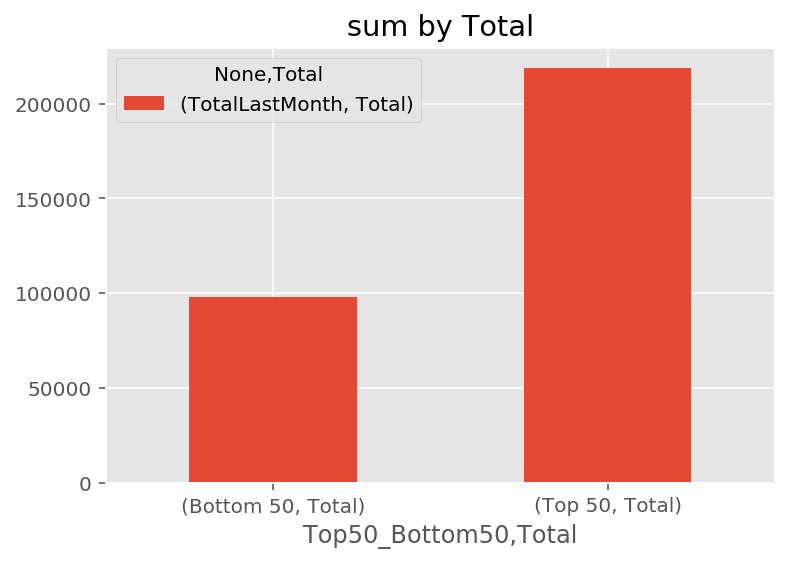

In [26]:
review_detail(df,'LastMonth',
              'Top50_Bottom50', "", 
              'Total', "", 
              'Total', 'sum', 
              False, 'total')

Top50_Bottom50     Bottom 50  Top 50
Total                  Total   Total
Total                  Total   Total
VoiceLastMonth         97395  102297
EquipmentLastMonth       599   63570
DataLastMonth            110   52744


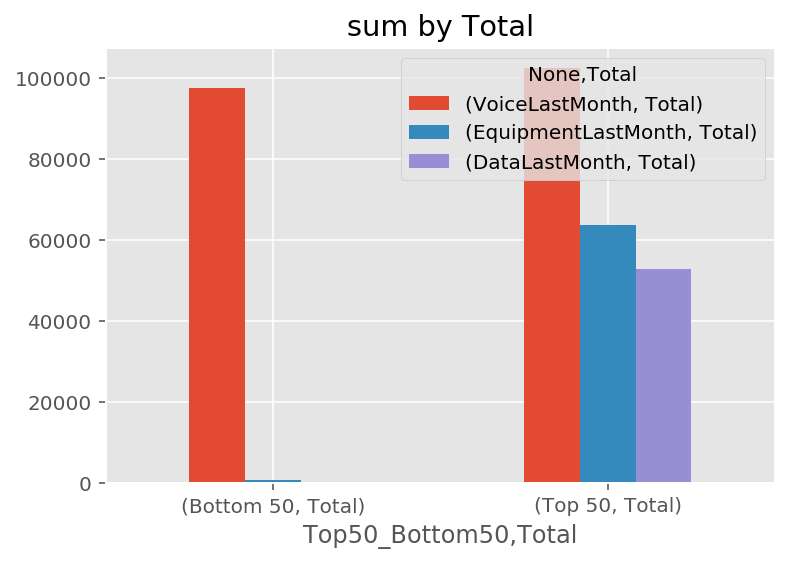

In [27]:
review_detail(df,'LastMonth',
              'Top50_Bottom50', "", 
              'Total', "", 
              'Total', 'sum', 
              False, 'else')

## Review Top and Bottom customers by Equipment Rental
    - Top Customers: 67% Rent Equipment
    - Bottom Customers: 1 % Rent Equipment

Top50_Bottom50  Top 50      
Total            Total      
EquipmentRental     No   Yes
TotalLastMonth     821  1679
pct_total           32    67


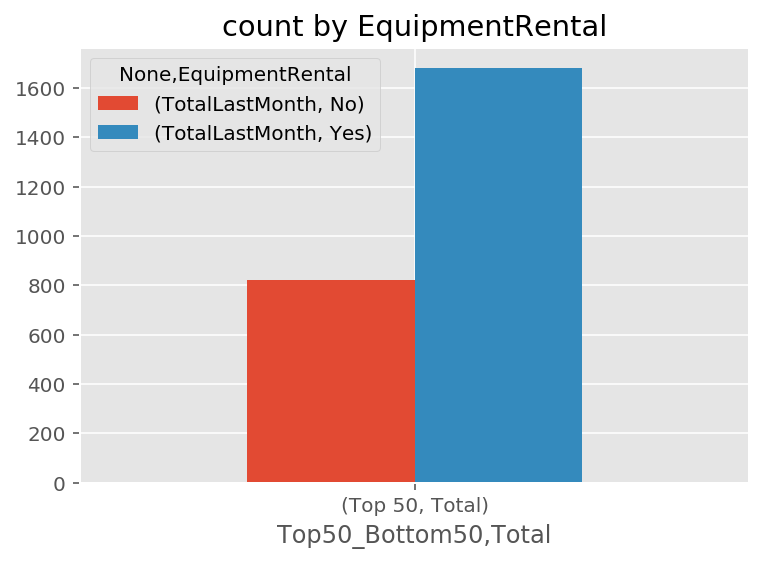

In [28]:
review_detail(top_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'EquipmentRental', "", 
              'Total', 'count', 
              False, 'total')

Top50_Bottom50  Bottom 50    
Total               Total    
EquipmentRental        No Yes
TotalLastMonth       2475  25
pct_total              99   1


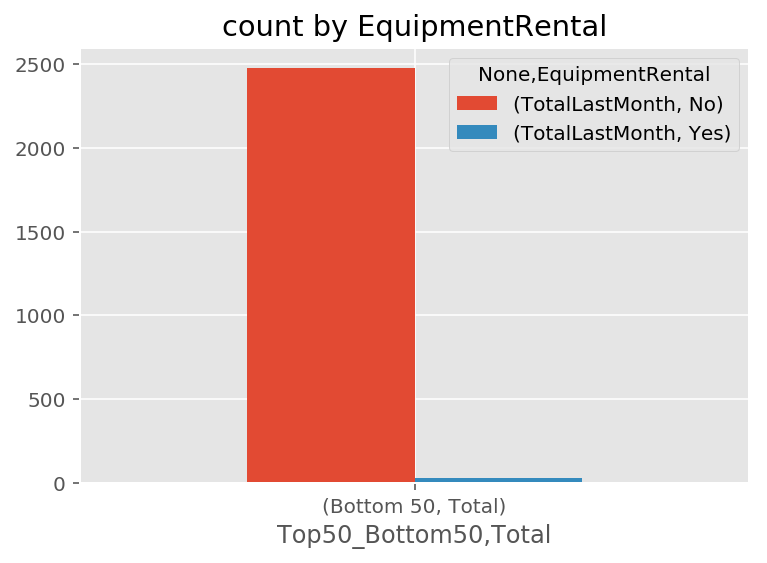

In [29]:
review_detail(bottom_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'EquipmentRental', "", 
              'Total', 'count', 
              False, 'total')

## Review Top and Bottom customers by Age and Equipment Rental
    - There is a potential to improve equipment rental within all age groups in the bottom pool of customers
    - The age pattern for the top half of customers matches the 'Total' pool of customers

Total          Total                           
Total          Total                           
AgeRanges          0    1    2    3     4     5
TotalLastMonth   106  419  634  867  1588  1386
pct_total          2    8   12   17    31    27


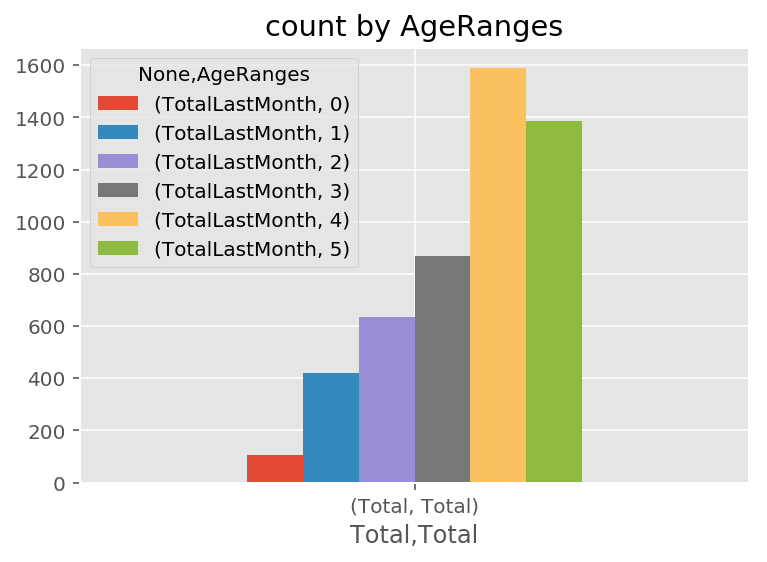

In [30]:
review_detail(df,'LastMonth',
              'Total', "", 
              'AgeRanges', "", 
              'Total', 'count', 
              False, 'total')

Top50_Bottom50  Top 50                                                    
AgeRanges            0       1        2         3         4         5     
EquipmentRental     No Yes  No  Yes  No  Yes   No  Yes   No  Yes   No  Yes
TotalLastMonth      53  27  97  161  92  294  128  347  239  525  212  325
pct_total            2   1   3    6   3   11    5   13    9   21    8   13


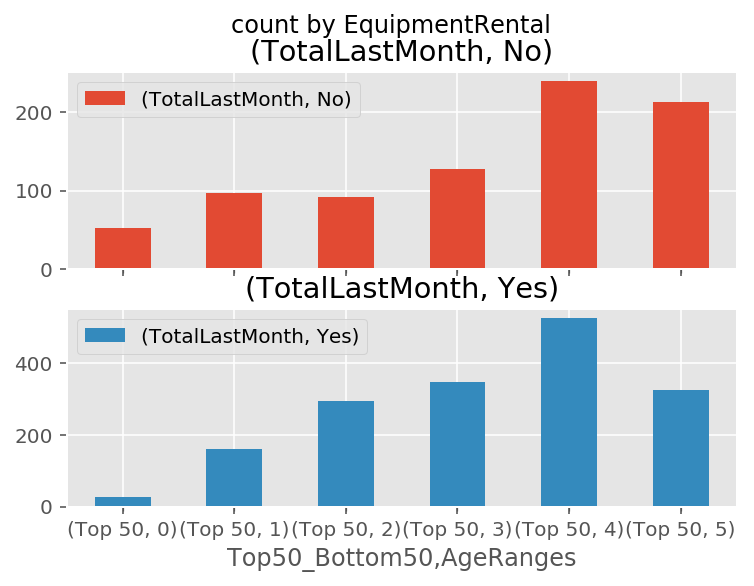

In [31]:
review_detail(top_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'EquipmentRental', "", 
              'AgeRanges', 'count', 
              True, 'total')

Top50_Bottom50  Bottom 50                                     
AgeRanges               0    1    2    3        4        5    
EquipmentRental        No   No   No   No Yes   No Yes   No Yes
TotalLastMonth         26  161  248  391   1  808  16  841   8
pct_total               1    6    9   15   0   32   0   33   0


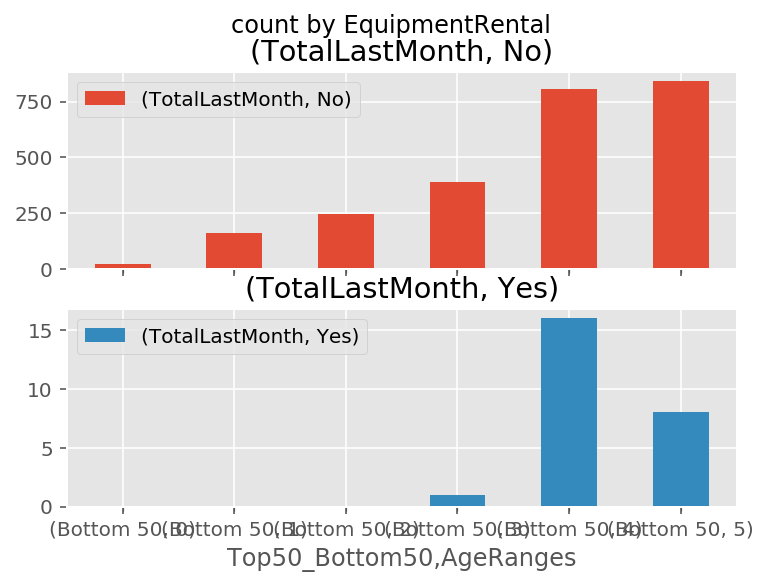

In [32]:
review_detail(bottom_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'EquipmentRental', "", 
              'AgeRanges', 'count', 
              True, 'total')

## Review Top and Bottom customers by HHIncome and Equipment Rental
    - There is a potential to improve equipment rental within all ranges of HHIncome in the bottom pool of customers
    - The potential bottom customers match the same pattern as the top customers and total pool

Total          Total                                    
HHIncomeRanges     0     1     2     3     4     5     6
Total          Total Total Total Total Total Total Total
TotalLastMonth   138  1752  1275  1254   472   102     7
pct_total          2    35    25    25     9     2     0


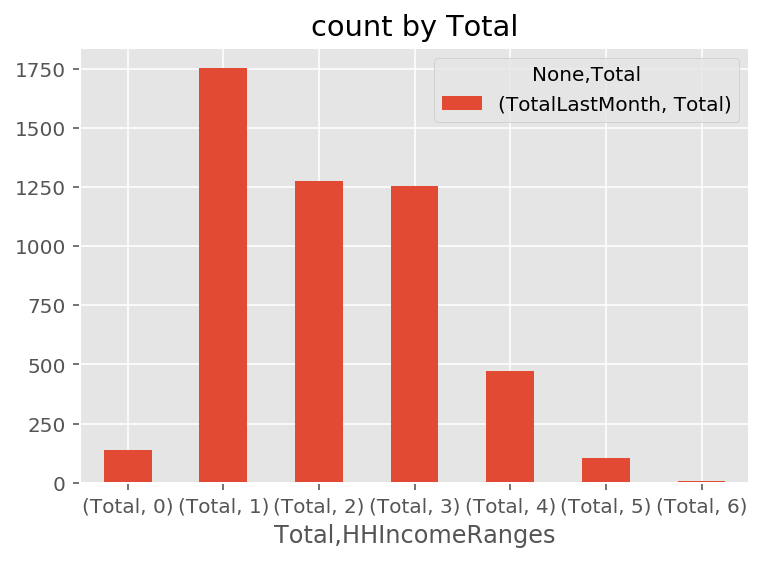

In [33]:
review_detail(df,'LastMonth',
              'Total', "", 
              'Total', "", 
              'HHIncomeRanges', 'count', 
              False, 'total')

Top50_Bottom50 Top 50                                                        
HHIncomeRanges      0        1        2        3        4        5      6    
OwnsPC             No Yes   No  Yes  No  Yes  No  Yes  No  Yes  No Yes No Yes
TotalLastMonth      4  30  149  702  89  523  88  553  40  244  13  59  1   5
pct_total           0   1    5   28   3   20   3   22   1    9   0   2  0   0


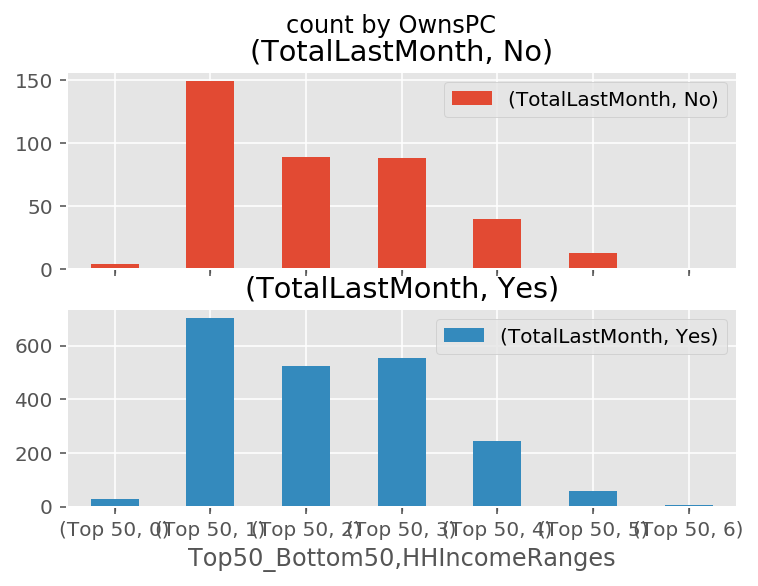

In [34]:
review_detail(top_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'OwnsPC', "", 
              'HHIncomeRanges', 'count', 
              True, 'total')

Top50_Bottom50 Bottom 50                                                     \
HHIncomeRanges         0        1         2         3         4       5       
OwnsPC                No Yes   No  Yes   No  Yes   No  Yes   No Yes  No Yes   
TotalLastMonth        59  45  524  377  386  277  355  258  109  79  19  11   
pct_total              2   1   20   15   15   11   14   10    4   3   0   0   

Top50_Bottom50      
HHIncomeRanges   6  
OwnsPC         Yes  
TotalLastMonth   1  
pct_total        0  


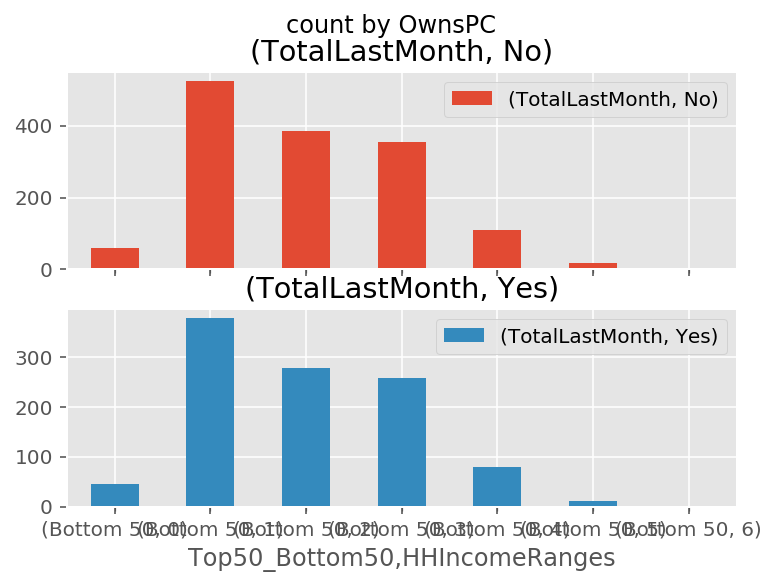

In [35]:
review_detail(bottom_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'OwnsPC', "", 
              'HHIncomeRanges', 'count', 
              True, 'total')

## Review Top and Bottom customers by TotalDebt
    - There is a potential to improve equipment rental within all ranges of HHIncome in the bottom pool of customers
    - The potential bottom customers match the same pattern as the top customers and total pool

Total           Total                               
Total           Total                               
TotalDebtRanges     0     1    2     3    4    5   6
TotalLastMonth    684  1649  976  1005  489  179  17
pct_total          13    32   19    20    9    3   0


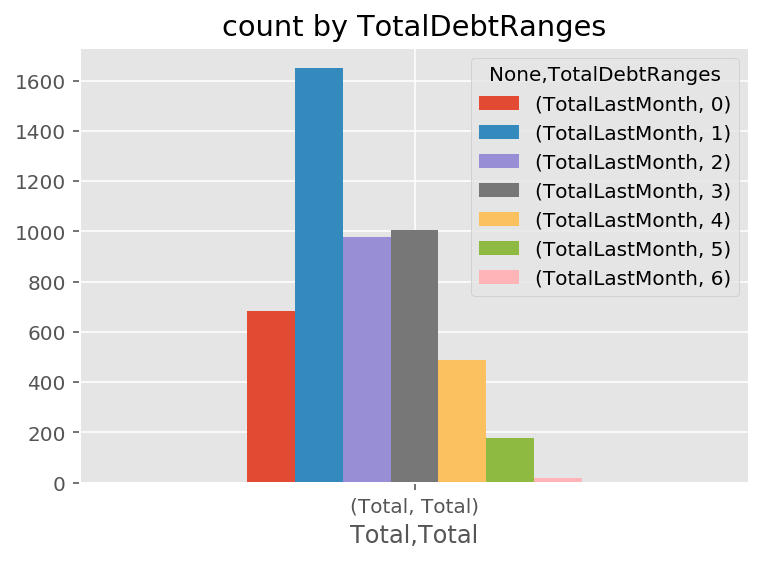

In [36]:
review_detail(df,'LastMonth',
              'Total', "", 
              'TotalDebtRanges', "", 
              'Total', 'count', 
              False, 'total')

Top50_Bottom50  Top 50                             
Total            Total                             
TotalDebtRanges      0    1    2    3    4    5   6
TotalLastMonth     321  797  485  519  256  107  14
pct_total           12   31   19   20   10    4   0


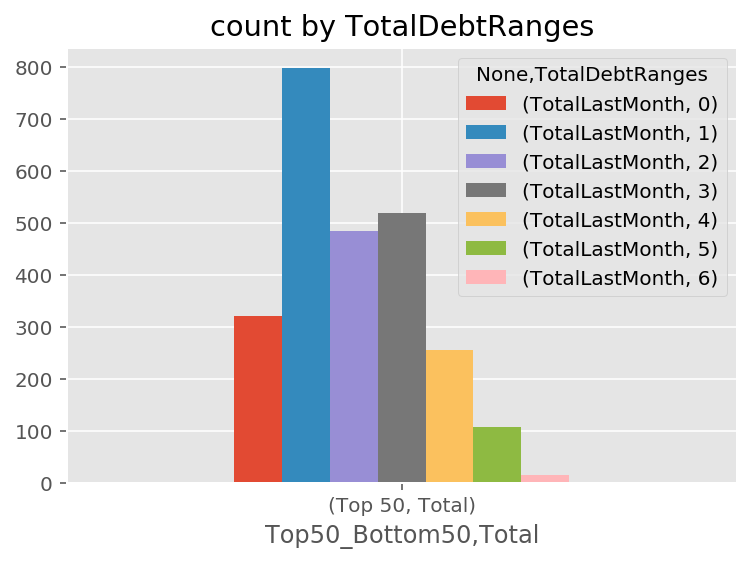

In [37]:
review_detail(top_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'TotalDebtRanges', "", 
              'Total', 'count', 
              False, 'total')

Top50_Bottom50  Bottom 50                           
Total               Total                           
TotalDebtRanges         0    1    2    3    4   5  6
TotalLastMonth        363  852  491  486  233  72  3
pct_total              14   34   19   19    9   2  0


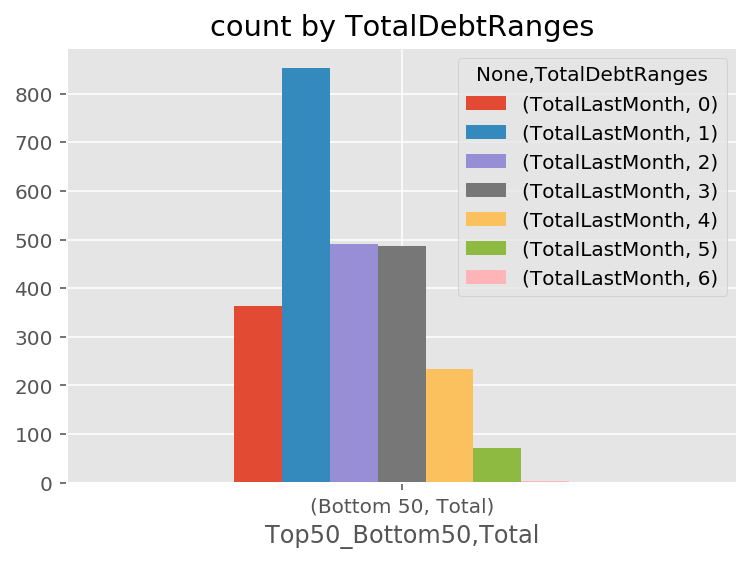

In [38]:
review_detail(bottom_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'TotalDebtRanges', "", 
              'Total', 'count', 
              False, 'total')

## Do the Bottom Half of Customers Have Internet?

Total          Total      
Total          Total      
Internet          No   Yes
TotalLastMonth  2498  2502
pct_total         49    50


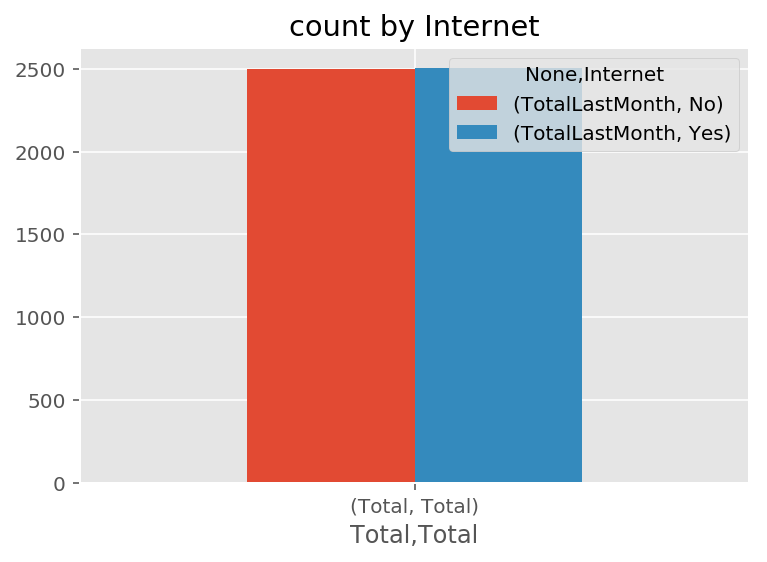

In [39]:
review_detail(df,'LastMonth',
              'Total', "", 
              'Internet', "", 
              'Total', 'count', 
              False, 'total')

## Review Top and Bottom customers by to assess who has Internet
    - There is an inverse relationship between top and bottom customers on who has Internet and who does not.
    - Top 74/26 split ; Bottom 26/74 split
    - Total is 50 / 50 split

Top50_Bottom50 Top 50      
Total           Total      
Internet           No   Yes
TotalLastMonth    641  1859
pct_total          25    74


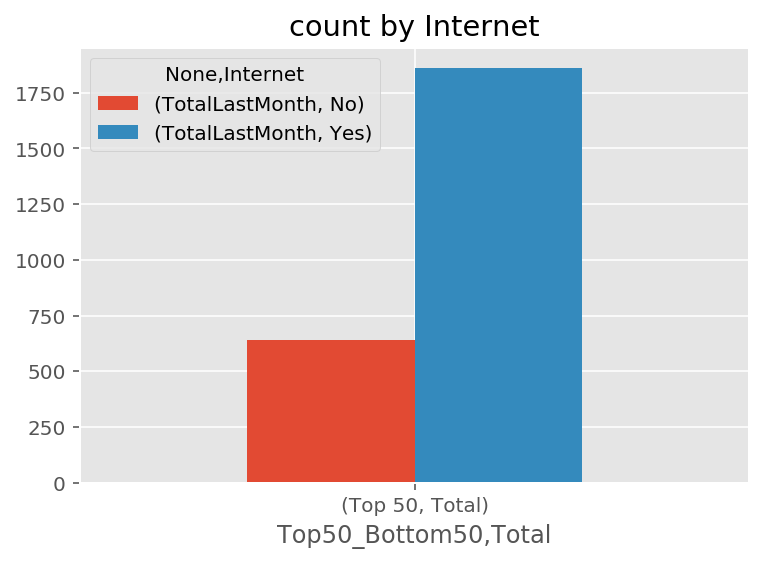

In [40]:
review_detail(top_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'Internet', "", 
              'Total', 'count', 
              False, 'total')

Top50_Bottom50 Bottom 50     
Total              Total     
Internet              No  Yes
TotalLastMonth      1857  643
pct_total             74   25


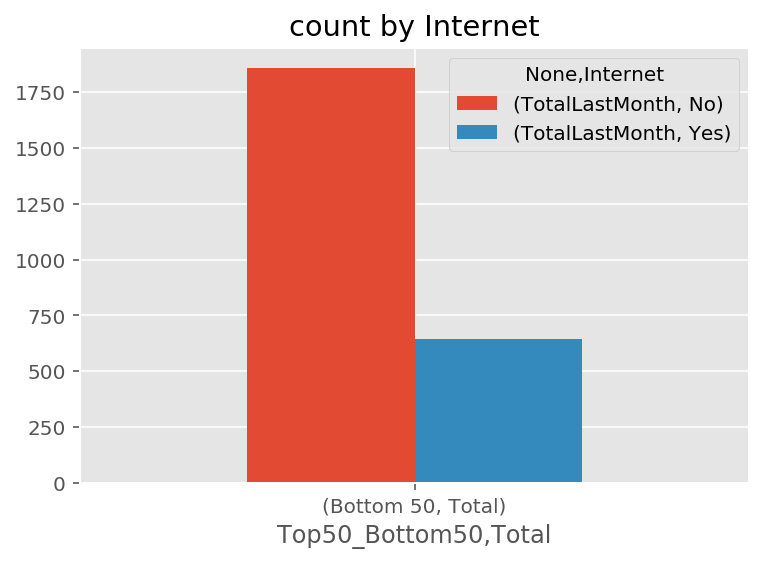

In [41]:
review_detail(bottom_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'Internet', "", 
              'Total', 'count', 
              False, 'total')

## Review Top and Bottom customers by to assess who has a Multiline Policy
    - There is an inverse relationship between top and bottom customers on who has Internet and who does not.
    - Top 60/40 split ; Bottom 40/60 split
    - Total is 49 / 51 split

Total          Total      
Total          Total      
Multiline         No   Yes
TotalLastMonth  2558  2442
pct_total         51    48


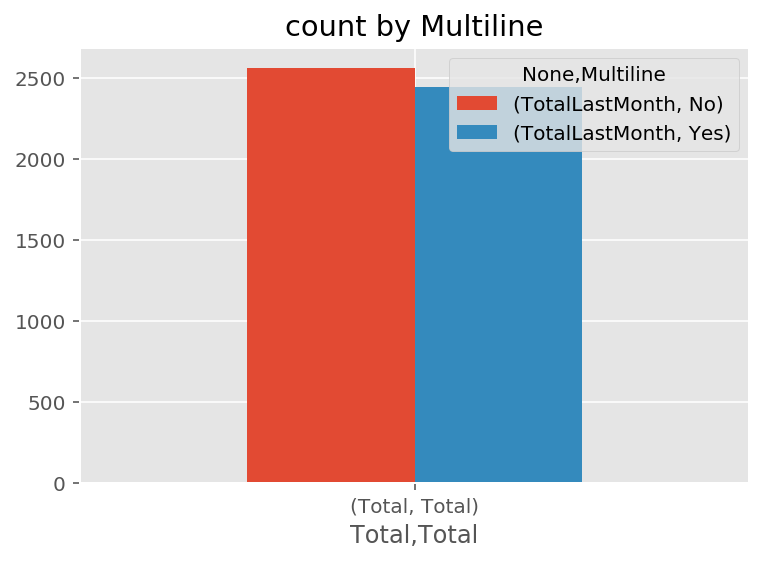

In [42]:
review_detail(df,'LastMonth',
              'Total', 1, 
              'Multiline', "", 
              'Total', 'count', 
              False, 'total')

Top50_Bottom50 Top 50      
Total           Total      
Multiline          No   Yes
TotalLastMonth   1019  1481
pct_total          40    59


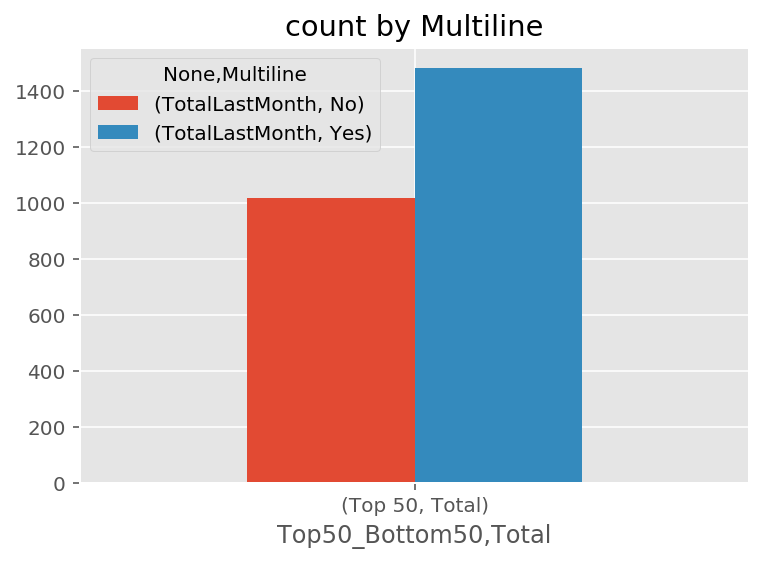

In [43]:
review_detail(top_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'Multiline', "", 
              'Total', 'count', 
              False, 'total')

Top50_Bottom50 Bottom 50     
Total              Total     
Multiline             No  Yes
TotalLastMonth      1539  961
pct_total             61   38


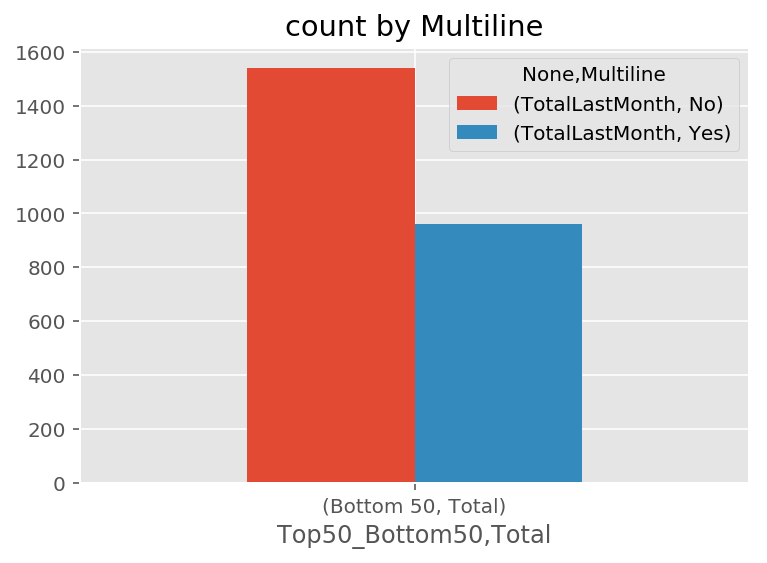

In [44]:
review_detail(bottom_customers_df,'LastMonth',
              'Top50_Bottom50', "", 
              'Multiline', "", 
              'Total', 'count', 
              False, 'total')

## Review Total Customer Base for Customers who:
    - Do not rent equipment compared to who owns a PC
        - Rent Equipment - 95% Own a PC
        - Does not Rent - 46% Own a PC

EquipmentRental    No         Yes      
Total           Total       Total      
OwnsPC             No   Yes    No   Yes
TotalLastMonth   1749  1547    87  1617
pct_total          34    30     1    32


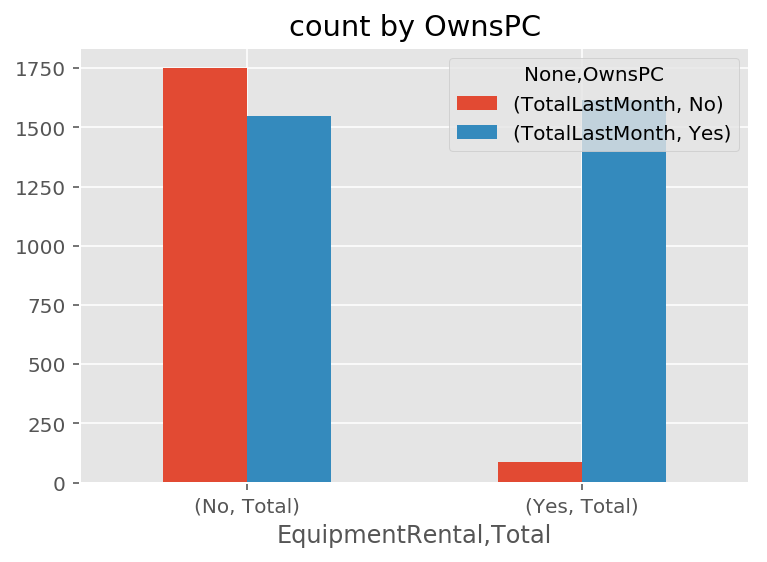

In [45]:
# Now assess Customers who rent equipment to see
# how many own as pc. 
# Results: 95% own a PC
review_detail(df,'LastMonth',
              'EquipmentRental', 1, 
              'OwnsPC', "", 
              'Total', 'count', 
              False, 'total')

EquipmentRental    No         Yes      
Total           Total       Total      
OwnsPC             No   Yes    No   Yes
TotalLastMonth   1749  1547    87  1617
pct_total          34    30     1    32


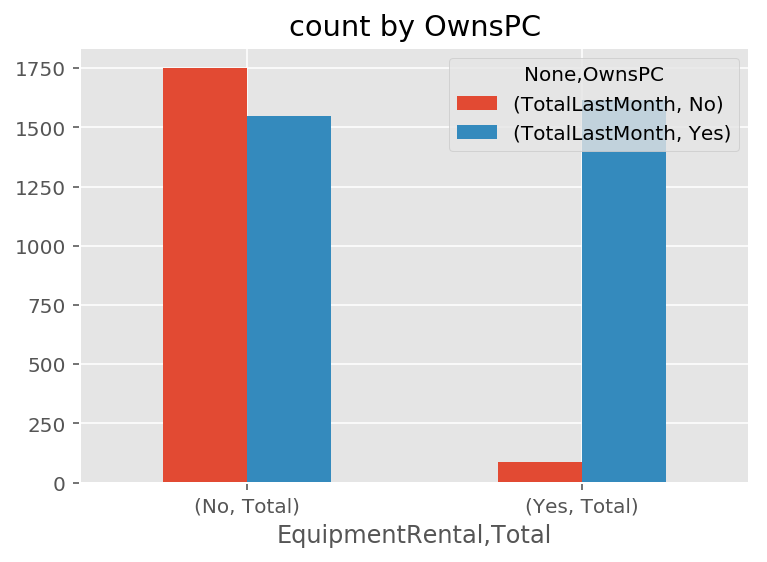

In [46]:
# Now assess Customers who rent equipment to see
# how many own as pc. 
# Results: 46% own a PC

review_detail(df,'LastMonth',
              'EquipmentRental', 0, 
              'OwnsPC', "", 
              'Total', 'count', 
              False, 'total')

## Review of Non-Retired Customer Base with Line of Business
    -No significant relationship confirmed
    -Missing (visual under construction)

In [47]:
# meas = 'sum'

# data = {'ThreeWayCalling':meas, 'VM':meas, 'Pager':meas, 
#         'CallingCard':meas, 'WirelessData':meas, 'CallerID':meas,
#         'CallWait':meas, 'CallForward':meas, 'Gender':'count'}

# print('Review of Non-Retired Customers and Lines of Business \n\n',
#     df.loc[df['Retired'] == "No"].groupby(by='Total').agg(data).T)

# selection = "Yes"
# df_plot = df.loc[df['Retired'] != selection]
# df_plot = df_plot.groupby(by='Total').agg(data)

# df_plot.plot(kind='bar')
# plt.show()

In [48]:
# meas = 'sum'

# data = {'ThreeWayCalling':meas, 'VM':meas, 'Pager':meas, 
#         'CallingCard':meas, 'WirelessData':meas, 'CallerID':meas,
#         'CallWait':meas, 'CallForward':meas, 'Gender':'count'}

# print('Review of All Customers and Lines of Business \n\n',
#       df.loc[df['Retired'] != 2].groupby(by='Total').agg(data).T)

# selection = 2
# df_plot = df.loc[df['Retired'] != selection]
# df_plot = df_plot.groupby(by='Total').agg(data)

# df_plot.plot(kind='bar')
# plt.show()

# Other Relationships Reviews

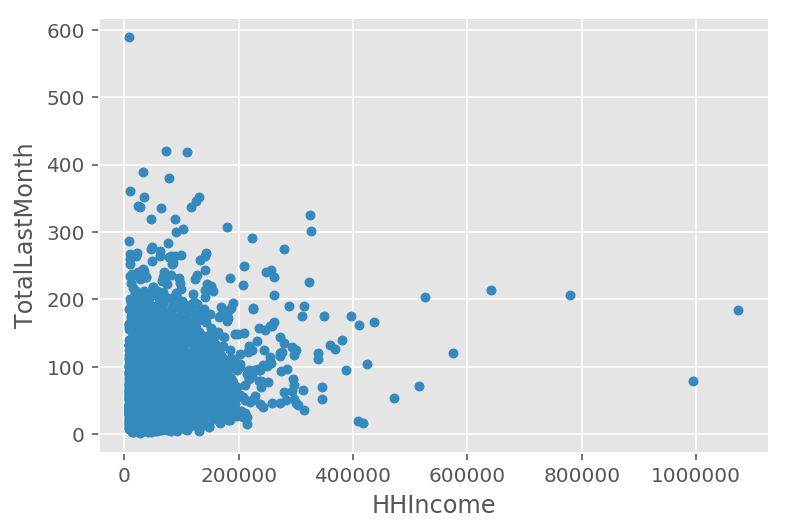

In [49]:
df.plot(kind='scatter', x = 'HHIncome', y = 'TotalLastMonth')

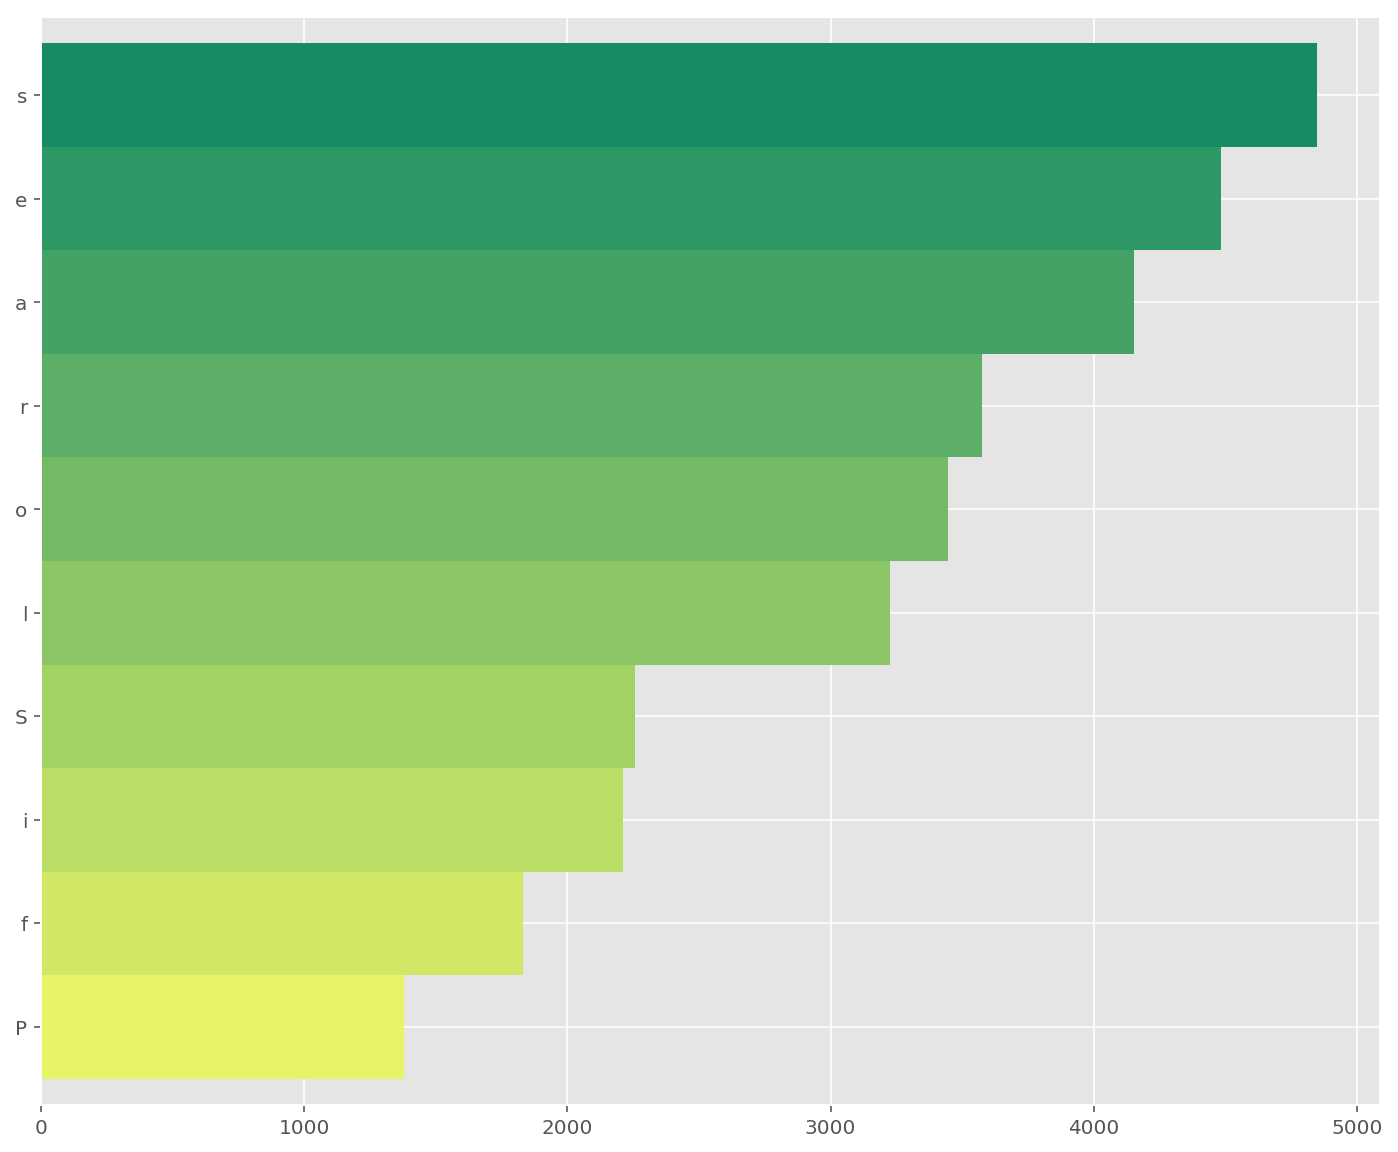

In [50]:
import seaborn as sns

plt.subplots(figsize=(12,10))
list1=[]

# extending the list of column values to populate in the bar chart
for i in df['JobCategory']:
    list1.extend(i)
 
column_count_series = pd.Series(list1).value_counts()[:10].sort_values(ascending=True)



ax = column_count_series.plot.barh(
    width=1,
    color=sns.color_palette('summer_r',10))

ax

### Marital Status
    - Unmarried = 0 ; Married = 1
 
### CarBrand
    - Domestic = 0 ; Foreign = 1 ; -1 = 2
    
### CarOwnership
    - Own = 0 ; Lease = 1 ; -1 = 2
    
### All Others
    - Yes = 0 ; No = 1
    
### Top50_Bottom50:
    - Top 50% of Customers = 0
    - Bottom 50% of Customers = 1

In [51]:
df.Gender.replace(['Male', 'Female'] , 
                  [0, 1],
                 inplace=True)
freq_dist(df, 'Gender')

   Gender  pct_total
1    2527     0.5054
0    2473     0.4946


In [52]:
df.MaritalStatus.replace(['Unmarried', 'Married'], 
                         [0, 1],
                        inplace=True)
freq_dist(df,'MaritalStatus')

   MaritalStatus  pct_total
0           2599     0.5198
1           2401     0.4802


In [53]:
df.CarBrand.replace(['Domestic','Foreign','-1'], 
                    [0, 1, 2],
                   inplace=True)
freq_dist(df,'CarBrand')

   CarBrand  pct_total
0      2287     0.4574
1      2216     0.4432
2       497     0.0994


In [54]:
df.CarOwnership.replace(['Own', 'Lease', '-1'], 
                        [0, 1, 2],
                       inplace=True)
freq_dist(df,'CarOwnership')

   CarOwnership  pct_total
0          3704     0.7408
1           799     0.1598
2           497     0.0994


In [55]:
df.Top50_Bottom50.replace(['Top 50','Bottom 50'], 
                    [0, 1],
                   inplace=True)
freq_dist(df,'Top50_Bottom50')

   Top50_Bottom50  pct_total
1            2500        0.5
0            2500        0.5


In [56]:
#Convert columns with "Yes" and "No" values to 0 and 1, respectively

cols = ['UnionMember', 'Retired', 'LoanDefault',
       'PoliticalPartyMem', 'Votes', 'ActiveLifestyle', 'EquipmentRental',
       'CallingCard', 'WirelessData', 'Multiline', 'VM', 'Pager', 'CallerID',
       'CallWait', 'CallForward', 'ThreeWayCalling', 'EBilling', 'OwnsPC',
       'OwnsMobileDevice', 'OwnsGameSystem', 'OwnsFax', 'NewsSubscriber', 
        'Internet']


for ea in range(len(cols)):
    df[cols[ea]] = df[cols[ea]].replace(['Yes','No'], [0, 1])

In [62]:
df['PhoneCoTenureYears'] = df.PhoneCoTenureYears.astype(int)
df['AgeRanges'] = df.AgeRanges.astype(int)
df['TotalDebtRanges'] = df.TotalDebtRanges.astype(int)
df['HHIncomeRanges'] = df.HHIncomeRanges.astype(int)

In [63]:
#Selecting only text columns to confirm above; There should be none other than 'CustomerID' before moving forward
text = ['object', 'category']
text_cols = df.select_dtypes(include= text)
print(text_cols.columns, '\n')
print(text_cols.shape)
text_cols.head(5).T

Index(['CustomerID', 'JobCategory', 'Total'], dtype='object') 

(5000, 3)


,2263,1277,2642,2920,315
CustomerID,0771-BLPWLO-QSL,7157-ZSGQGF-P1D,5770-HZVHOG-OX6,7842-IOOPJQ-LS8,2591-HAWSSX-B1M
JobCategory,Service,Sales,Sales,Sales,Professional
Total,Total,Total,Total,Total,Total


# Assess What Columns to Keep for Next Portion of Project

## Groups:

   ### Top and Bottom Customers
    - 'Top50_Bottom50'

   ### Geographic Location / Demographics
    - 'Region', 'TownSize', 'Gender', 'Age', 'EducationYears', 'MaritalStatus, 'HouseholdSize'

   ### Customer Job Details
    - 'JobCategoryNo', , 'EmploymentLength', 'Retired', 'HHIncome', 'CommuteTime',
    
   ### Customer Financial Details
    - 'LoanDefault', 'TotalDebt', 'HomeOwner'
    
   ### Customer Value:
       - Last Month's Sales: 'VoiceLastMonth', , 'DataLastMonth', 'EquipmentLastMonth'
       - Over Tenure Sales: 'VoiceOverTenure', 'EquipmentOverTenure', 'DataOverTenure'
       - Over Tenure Sales per Month: 'VoicePerMonth', 'EquipmentPerMonth', 'DataOverTenure'
           (***OverTenure values divided by PhoneCoTenure)
       - Added Last Month values together (Voice+Equipment+Data) to create 'Total' column
       
   ### Relationship:
       - 'PhoneCoTenure', 'VM', 'Pager','CallingCard', 'WirelessData', 'Multiline'
       - 'CallerID', 'CallWait','CallForward', 'ThreeWayCalling', 'Internet'
       - 'EBilling', 'TVWatchingHours','OwnsPC', 'OwnsMobileDevice', 
       - 'OwnsGameSystem', 'OwnsFax','NewsSubscriber', 'EquipmentRental'
       - PhoneCoTenureYears
       
## Removing So Far: 
       - 'Age', 'UnionMember', 'DebtToIncomeRatio', 'CreditDebt', 'OtherDebt'
       - 'CardTenure', 'CardItemsMonthly', 'CardSpendMonth', 'CarsOwned', 
       - 'CarOwnership', 'CarBrand', 'CarValue',  'PoliticalPartyMem', 'Votes'
       
** Added a 'Total' column so that I can group the entire dataset as needed

In [ ]:
df.columns

#Columns to keep: 'CommuteTime', 'Age', 'EducationYears', 'JobCategory', 'EmploymentLength', 'DebtToIncomeRatio_rec', 